In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-03-31 23:12:50--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-03-31 23:12:50--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  28.6MB/s    in 28s     

2022-03-31 23:13:18 (27.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-03-31 23:13:18--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

In [2]:
import os
if input("Are you using Google Colab? y/n") in ['y','Y']:
  import os
  input_dir = "images/"
  target_dir = "annotations/trimaps/"
  input_img_paths = sorted(
      [os.path.join(input_dir, fname)
  for fname in os.listdir(input_dir)
  if fname.endswith(".jpg")])
  target_paths = sorted(
      [os.path.join(target_dir, fname)
  for fname in os.listdir(target_dir)
  if fname.endswith(".png") and not fname.startswith(".")])
else:
  input_dir ='C:/downloads/images'
  target_dir='C:/downlaods/annotations/trimaps'

Are you using Google Colab? y/ny


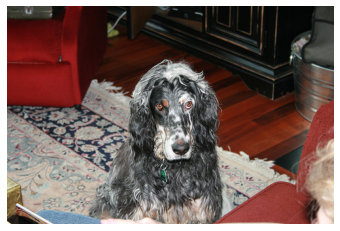

In [3]:
import matplotlib.pyplot as plt
import numpy as np
rand = np.random.choice(100)
np.random.seed(rand)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[np.random.choice(len(input_img_paths))]))

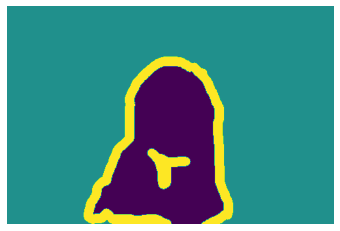

In [4]:
np.random.seed(rand)
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
img = img_to_array(load_img(target_paths[np.random.choice(len(target_paths))], color_mode="grayscale"))
display_target(img)

In [5]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
    img = img_to_array(
load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(3, num_classes, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
epochs=30,
callbacks=callbacks,
batch_size=64,
validation_data=(val_input_imgs, val_targets))

Epoch 1/30
100/100 [==============================] - 159s 1s/step - loss: 1.7036 - val_loss: 0.9002
Epoch 2/30
100/100 [==============================] - 128s 1s/step - loss: 0.8906 - val_loss: 0.7993
Epoch 3/30
100/100 [==============================] - 127s 1s/step - loss: 0.8114 - val_loss: 0.7776
Epoch 4/30
100/100 [==============================] - 128s 1s/step - loss: 0.7883 - val_loss: 0.7269
Epoch 5/30
100/100 [==============================] - 128s 1s/step - loss: 0.7445 - val_loss: 0.6874
Epoch 6/30
100/100 [==============================] - 128s 1s/step - loss: 0.6859 - val_loss: 0.6417
Epoch 7/30
100/100 [==============================] - 128s 1s/step - loss: 0.6561 - val_loss: 0.6440
Epoch 8/30
100/100 [==============================] - 128s 1s/step - loss: 0.6224 - val_loss: 0.6972
Epoch 9/30
100/100 [==============================] - 128s 1s/step - loss: 0.5906 - val_loss: 0.5568
Epoch 10/30
100/100 [==============================] - 128s 1s/step - loss: 0.5808 - val_lo

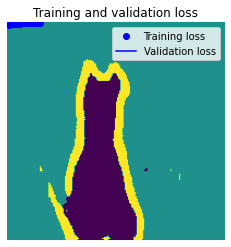

In [8]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()



In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
display_mask(mask)